# End-to-end DeepCell Benchmark

This notebook runs an input image through the DeepCell Mesmer application to generate whole-cell cellular segmentation predictions. It benchmarks the above along several measures. (todo: document benchmark CSV output format)

This notebook accepts a numpy array of two input channels: the nuclear & membrane channels in that order. The array must be named `input_channels` in an `npz` file.

The array is given as a URL, for example: `gs://a-data-bucket/a-path/input_channels.npz`. In principle `smart_open` works for "all" cloud providers but I have only tested (+ specified dependencies) for GCS (Google Cloud Storage).

The notebook optionally outputs the predicted segments to `predictions_output_path` if provided, into an `npz` file containing a single array: `predictions`.

If the `visualize` parameter is `True`, the notebook generates 2 image files: `input_png_output_path` and `predictions_png_output_path`. A green/blue visualization will be written to `input_png_output_path`, and the same visualization with predictions overlaid will be written to `predictions_png_output_path`.

## Notebook setup

Install dependencies & import libraries.

Note that the first install might report some scary errors about packages being not found and pip's default behavior. These are safe to ignore and should go away on subsequent runs.

In [1]:
import logging
try:
  import deepcell
except:
  logging.error("Couldn't load deepcell module. Run the setup notebook.")
  raise

In [2]:
# Imports

import csv
from datetime import datetime, timezone
import deepcell
from deepcell.applications import Mesmer
import io
import logging
import math
import numpy as np
import os
import psutil
import re
import resource
import smart_open
import tensorflow as tf
import timeit
import urllib.parse

In [3]:
# We need to import the cached_open module at the repository root.

# But because we're not shipping the deepcell_imaging module as a proper python package,
# we need to import the module a bit bluntly. This loads the module direct filename,
# relative to this notebook. Then, it's available like usual.

import importlib

file_path = "../../deepcell_imaging/__init__.py"
module_name = "deepcell_imaging"
spec = importlib.util.spec_from_file_location(module_name, file_path)
module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)

from deepcell_imaging import cached_open

## Parameters

Parameters:

* `input_channels_path` (required): the URL to the input numpy array containing 2 input channels (nuclear & membrane).
* `model_path` : the URL to the MultiplexSegmentation Tensorflow Keras model.
* `predictions_output_path` : the URL to write predictions, or `None`/`""` if not saving predictions.

In [4]:
# This cell is a notebook 'parameters' cell.
# Utilities like Vertex AI or Papermill can override them for an execution.

input_channels_path = 'gs://davids-genomics-data-public/cellular-segmentation/deep-cell/vanvalenlab-multiplex-20200810_tissue_dataset/mesmer-sample-3-dev/input_channels.npz'

# The location of the TensorFlow model to download.
# The tarball needs to extract to the directory: 'MultiplexSegmentation'
model_remote_path = 'gs://davids-genomics-data-public/cellular-segmentation/deep-cell/vanvalenlab-tf-model-multiplex-downloaded-20230706/MultiplexSegmentation.tar.gz'
model_hash = 'a1dfbce2594f927b9112f23a0a1739e0'

# The local cache location
model_path = os.path.expanduser('~') + '/.keras/models/MultiplexSegmentation'

predictions_output_path = None
# predictions_output_path = 'gs://davids-genomics-data-public/cellular-segmentation/deep-cell/vanvalenlab-multiplex-20200810_tissue_dataset/mesmer-sample-3-dev/segmentation_predictions.npz'

project_id = 'deepcell-401920'
location = 'us-west1'
# Set to None for local execution.
notebook_runtime_id = "managed-notebook-20231201-160823"

# Set this to True to visualize & save input & prediction.
# If true, the paths may be provided to save the visualizations to storage.
visualize = True
input_png_output_path = None
predictions_png_output_path = None
# input_png_output_path = 'gs://davids-genomics-data-public/cellular-segmentation/deep-cell/vanvalenlab-multiplex-20200810_tissue_dataset/mesmer-sample-3-dev/input.png'
# predictions_png_output_path = 'gs://davids-genomics-data-public/cellular-segmentation/deep-cell/vanvalenlab-multiplex-20200810_tissue_dataset/mesmer-sample-3-dev/segmentation_predictions.png'

# Benchmark warm-up

It takes tens of seconds to load the Mesmer tensorflow model. Let's assume a production environment would have this primed already. Here we handle such priming aka warm-up as well as Python imports.

In [5]:
# Model warm-up

logger = logging.getLogger()
old_level = logger.getEffectiveLevel()
logger.setLevel(logging.INFO)

try:
    assert model is not None
    logging.info("Using warmed-up model")
except (NameError, AssertionError):
    downloaded_file_path = cached_open.get_file(
        'MultiplexSegmentation.tgz',
        model_remote_path,
        file_hash=model_hash,
        extract=True,
        cache_subdir='models',
    )
    # Remove the .tgz extension to get the model directory path
    model_path = os.path.splitext(downloaded_file_path)[0]
        
    logging.info("Loading model from {}.".format(model_path))
    t = timeit.default_timer()
    model = tf.keras.models.load_model(model_path)
    logging.info("Loaded model in %s s" % (timeit.default_timer() - t))
finally:
    app = Mesmer(model=model)
    pass
    
# Need to reset top-level logging for intercept to work.
# I dunno 🤷🏻‍♂️ There's probably a better way to do this...
logger.setLevel(old_level)
logging.basicConfig(force=True)

INFO:root:Loading model from /Users/davidhaley/.keras/models/MultiplexSegmentation.
2023-12-02 23:08:42.921773: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:root:Loaded model in 26.755694124032743 s


# End-to-end Prediction

This re-runs the benchmark from the warmed-up app & parameters.

In [6]:
start_time = timeit.default_timer()

# Load inputs

t = timeit.default_timer()
with smart_open.open(input_channels_path, 'rb') as input_channel_file:
    with np.load(input_channel_file) as loader:
        # An array of shape [height, width, channel] containing intensity of nuclear & membrane channels
        input_channels = loader['input_channels']
input_load_time_s = timeit.default_timer() - t

print('Loaded input in %s s' % input_load_time_s)

# Generate predictions

## Intercept log (many shenanigans, such hacking)
logger = logging.getLogger()
old_level = logger.getEffectiveLevel()
logger.setLevel(logging.DEBUG)
logs_buffer = io.StringIO()
buffer_log_handler = logging.StreamHandler(logs_buffer)
logger.addHandler(buffer_log_handler)

## The actual prediction

t = timeit.default_timer()

try:
    segmentation_predictions = app.predict(input_channels[np.newaxis, ...], image_mpp=0.5)[0]
    prediction_success = True
    
except Exception as e:
    # The exception is nom-nom'd. Safe? We'll see 🤔
    prediction_success = False
    logger.error('Prediction exception: %s', e)

prediction_time_s = timeit.default_timer() - t
total_time_s = timeit.default_timer() - start_time

## Undo log intercept
logger.removeHandler(buffer_log_handler)
logger.setLevel(old_level)

## Wrap up
print('Prediction finished in %s s' % prediction_time_s)
print('Overall operation finished in %s s' % total_time_s)

DEBUG:Mesmer:Pre-processing data with mesmer_preprocess and kwargs: {}
DEBUG:Mesmer:Pre-processed data with mesmer_preprocess in 0.07949900097446516 s


Loaded input in 3.29883871198399 s


DEBUG:Mesmer:Model inference finished in 4.4967002749908715 s
DEBUG:Mesmer:Post-processing results with mesmer_postprocess and kwargs: {'whole_cell_kwargs': {'maxima_threshold': 0.075, 'maxima_smooth': 0, 'interior_threshold': 0.2, 'interior_smooth': 2, 'small_objects_threshold': 15, 'fill_holes_threshold': 15, 'radius': 2}, 'nuclear_kwargs': {'maxima_threshold': 0.1, 'maxima_smooth': 0, 'interior_threshold': 0.2, 'interior_smooth': 2, 'small_objects_threshold': 15, 'fill_holes_threshold': 15, 'radius': 2}, 'compartment': 'whole-cell'}
DEBUG:Mesmer:Post-processed results with mesmer_postprocess in 0.24019920895807445 s


Prediction finished in 4.8837663370068185 s
Overall operation finished in 8.18352031899849 s


In [7]:
# Parse the intercepted debug logs to extract step timing.

debug_logs = logs_buffer.getvalue()
pattern = r"(?sm)Pre-processed data with mesmer_preprocess in (.+?) s.*Model inference finished in (.+?) s.*Post-processed results with mesmer_postprocess in (.+?) s"
match = re.search(re.compile(pattern, re.MULTILINE), debug_logs)

if match:
    preprocess_time_s = float(match.group(1))
    inference_time_s = float(match.group(2))
    postprocess_time_s = float(match.group(3))
else:
    logger.warning("Couldn't parse step timings from debug_logs")
    preprocess_time_s = inference_time_s = postprocess_time_s = math.nan

## Save predictions [optional]

In [8]:
if predictions_output_path:
    with smart_open.open(predictions_output_path, 'wb') as predictions_file:
        np.savez_compressed(predictions_file, predictions=segmentation_predictions)

# Visualization [optional]

## Input channel visualization

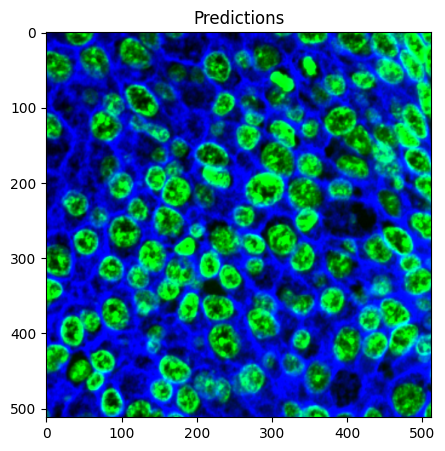

In [9]:
if visualize:
    from deepcell.utils.plot_utils import create_rgb_image
    from PIL import Image

    nuclear_color = 'green'
    membrane_color = 'blue'

    # Create rgb overlay of image data for visualization
    # Note that this normalizes the values from "whatever" to rgb range 0..1
    input_rgb = create_rgb_image(input_channels[np.newaxis, ...], channel_colors=[nuclear_color, membrane_color])[0]

    if input_png_output_path:
        # The png needs to normalize rgb values from 0..1, so normalize to 0..255
        im = Image.fromarray((input_rgb * 255).astype(np.uint8))
        with smart_open.open(input_png_output_path, 'wb') as input_png_file:
            im.save(input_png_file, mode='RGB')
        del im

    from matplotlib import pyplot as plt

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(input_rgb)
    ax.set_title('Predictions')
    plt.show()

## Prediction overlay visualization

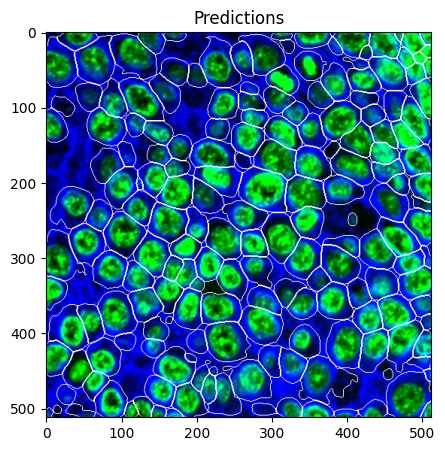

In [10]:
if visualize:
    from deepcell.utils.plot_utils import make_outline_overlay
    
    overlay_data = make_outline_overlay(
        rgb_data=input_rgb[np.newaxis, ...],
        predictions=segmentation_predictions[np.newaxis, ...],
    )[0]

    from PIL import Image

    if predictions_png_output_path:
        # The rgb values are 0..1, so normalize to 0..255
        im = Image.fromarray((overlay_data * 255).astype(np.uint8))
        with smart_open.open(predictions_png_output_path, 'wb') as predictions_png_file:
            im.save(predictions_png_file, mode='RGB')
        del im

    from matplotlib import pyplot as plt

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(overlay_data)
    ax.set_title('Predictions')
    plt.show()

# Benchmark data

In [11]:
headers = [
    'Input file id', 'Image size (MB)', 'Benchmark datetime (UTC)',
    'Machine type', 'GPU type', '# GPUs', 'Kernel',
    'Success?', 'Total time (s)', 'Peak memory (GB)',
    'Load time (s)', 'Total prediction time (s)', 'Prediction overhead (s)',
    'Predict preprocess time (s)', 'Predict inference time (s)', 'Predict postprocess time (s)',
    'deepcell-tf version'
]

parsed_url = urllib.parse.urlparse(input_channels_path)
filename = parsed_url.path.split("/")[-2]
image_size = round(input_channels.nbytes / 1000 / 1000, 2)

import ipykernel
kernel_name = ipykernel.connect.get_connection_info(unpack=True)["kernel_name"]

if notebook_runtime_id:
    # For running on vertex AI:
    try:
        from google.cloud import notebooks_v1
        client = notebooks_v1.ManagedNotebookServiceClient()
        request = notebooks_v1.GetRuntimeRequest(
            name="projects/{}/locations/{}/runtimes/{}".format(project_id, location, notebook_runtime_id),
        )
        response = client.get_runtime(request=request)
        machine_type = response.virtual_machine.virtual_machine_config.machine_type
    except Exception as e:
        logging.error('Error getting machine type: ' + str(e))
        machine_type = 'error'
else:
    # assume a generic python environment
    # See also:
    # https://docs.python.org/3.10/library/os.html#os.cpu_count
    try:
        num_cpus = len(os.sched_getaffinity(0))
    except AttributeError:
        num_cpus = os.cpu_count()
    total_mem = psutil.virtual_memory().total
    machine_type = 'local {} CPUs {} GB RAM'.format(num_cpus, round(total_mem/1000000000, 1))

peak_mem_b = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
prediction_overhead_s = prediction_time_s - preprocess_time_s - inference_time_s - postprocess_time_s

# Write benchmarking data as CSV:

output = io.StringIO()
writer = csv.writer(output, quoting=csv.QUOTE_NONNUMERIC)
writer.writerow(headers)

deepcell_version = deepcell.__version__

writer.writerow([
    filename, image_size, datetime.now(timezone.utc),
    machine_type, 'todo-gpu-type', 'todo-gpu-count', kernel_name,
    prediction_success, round(total_time_s, 2), round(peak_mem_b / 1000000000, 1),
    round(input_load_time_s, 2), round(prediction_time_s, 2), round(prediction_overhead_s, 2),
    round(preprocess_time_s, 2), round(inference_time_s, 2), round(postprocess_time_s, 2),
    deepcell_version,
])

print(output.getvalue())

"Input file id","Image size (MB)","Benchmark datetime (UTC)","Machine type","GPU type","# GPUs","Kernel","Success?","Total time (s)","Peak memory (GB)","Load time (s)","Total prediction time (s)","Prediction overhead (s)","Predict preprocess time (s)","Predict inference time (s)","Predict postprocess time (s)","deepcell-tf version"
"mesmer-sample-3-dev",4.19,"2023-12-03 07:09:14.013598+00:00","local 12 CPUs 17.2 GB RAM","todo-gpu-type","todo-gpu-count","python3",True,8.18,2.5,3.3,4.88,0.07,0.08,4.5,0.24,"0.12.9"

